### Imports

In [32]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from MALDI_class import MALDI, rawMALDI, binnedMALDI, selectedMALDI
from metaspace_class import metaspace

### Set file parameters

In [19]:
raw_data_folder = '/data/datadata/40_MALDI/MALDI/'
#'/data/pt_02040/MyelinQuantificationProject/raw_data/MALDI/'
results_folder = 'expdata/final/'
#'/data/pt_02040/MyelinQuantificationProject/results_final/

samples = np.loadtxt(results_folder + 'samples.csv', dtype = str)#pattern: 'brain{sample}re_{section}_{ROI}
paths = [raw_data_folder + samples[i].split('_')[0] + '-' + samples[i].split('_')[1] + '/' + samples[i].split('_')[2] + '/RAW-Data/' + samples[i].split('_')[0] + '-' + samples[i].split('_')[1] + '_' + samples[i].split('_')[2] + '_pos' + '.imzML' for i in range(len(samples))]

### Set MALDI data parameters

In [20]:
resolution = 1e-5

### Set METASPACE parameters

In [26]:
### Database parameters ###
name = results_folder + 'metaspacefiltering'

metaspaceparams = {
	'databases' : ['HMDB', 'SwissLipids', 'LipidMaps'],
	'max_fdr' : .05,
	}

### Matrix reference measurement parameters ###
matrixproject = 'b9195154-ba0d-11eb-96db-bbe19b6ae1a2'
matrixdataset = ['2021-05-21_10h24m13s', '2021-06-09_13h10m10s', '2021-07-02_15h25m26s']

### SAMPLE IDENTIFIERS FOR OLD, GREY NEW AND BRIGHT NEW DATA ###
metaspaceproject = '7cee7ac4-4417-11e9-9d77-9bd44815e670'
metaspacedatasets = ['2020-11-16_10h33m20s', '2020-11-16_11h15m09s', '2020-11-16_11h12m13s', '2020-11-16_11h12m42s', '2020-11-16_11h13m38s', '2020-11-16_11h18m12s', '2020-11-16_11h21m21s', '2020-11-16_11h23m40s']

metaspaceproject_new = 'ede04eea-ace5-11eb-96db-8f5be2c20812'
newmetaspacedatasets = ['2021-06-09_13h35m04s', '2021-06-16_13h55m34s', '2021-06-17_08h45m52s', '2021-06-21_10h06m57s', '2021-06-22_09h48m51s', '2021-06-28_09h54m04s', '2021-06-30_12h32m41s']
#USE THE NEW SINGLE REPOSITORY AND HOPE FOR THE SAME DATA IF THE DATA IS NOT THE SAME, MAKE NEW METASPACE PROJECT FROM THE OLD FILES AND DONT UPLOAD NEW
#project_id = '1ffdfd2a-c223-11ec-89bf-e73a6b23aeb6'
#dataset_ids = ['2022-04-22_13h52m40s', '2022-04-22_13h54m55s', '2022-04-22_13h43m51s', '2022-04-22_13h57m55s', '2022-04-22_13h58m27s', '2022-04-22_13h57m25s', '2022-04-22_13h59m24s', '2022-04-22_14h00m05s', '2022-04-22_13h39m38s', '2022-04-22_13h47m06s', '2022-04-22_13h40m58s', '2022-04-22_13h53m03s', '2022-04-22_13h50m55s', '2022-04-22_13h53m22s']


### Get matrix annotations

In [35]:
matrix = metaspace(matrixdataset, databases = metaspaceparams['databases'], proj_id = matrixproject)
matrix.get_datasets(drop_duplicates = False, sort_by = ['mz'])
matrixmzs = np.unique(matrix.data.mz.values)
#manually selected matrix ions
matrixions = ['C27H46O4+Na+', 'C47H79NO8+Na+', 'C42H82NO11P+H+', 'C49H83NO8+Na+', 'C19H14O9+Na+', 'C10H15N5O9P2+H+', 'C24H40O4+Na+', 'C24H50NO7P+K+', 'C30H58NO10P+H+', 'C38H77NO4+Na+', 'C31H60NO10P+H+', 'C42H81NO3+H+', 'C32H62NO10P+H+', 'C40H81NO4+Na+', 'C41H83NO5+Na+', 'C37H71O8P+K+', 'C40H66O12+H+', 'C41H77O8P+K+', 'C43H76NO7P+Na+', 'C45H78NO7P+Na+', 'C42H81O10P+Na+', 'C45H80NO7P+Na+', 'C47H82NO7P+Na+', 'C46H90NO10P+H+', 'C47H93N2O6P+K+', 'C47H92NO8P+Na+', 'C46H90NO11P+H+', 'C48H94NO7P+K+', 'C20H36O2+H+', 'C20H43NO+H+', 'C21H36O5+Na+', 'C25H46O2+Na+', 'C23H47NO4+H+', 'C22H28O6+Na+', 'C30H50+Na+', 'C36H75N+H+', 'C26H54NO7P+H+', 'C40H81NO3+Na+', 'C42H81NO3+H+', 'C33H64NO9P+H+', 'C33H64NO10P+H+', 'C35H68NO9P+H+', 'C33H64NO10P+Na+', 'C35H68NO10P+Na+', 'C41H72O10+H+', 'C41H83N2O6P+H+', 'C23H34O5+H+', 'C27H44O2+H+', 'C26H38O4+H+', 'C37H70O12S+H+', 'C40H80NO8P+K+', 'C42H82NO8P+K+', 'C42H84NO8P+K+', 'C44H86NO8P+K+', 'C49H90NO8P+H+', 'C46H92NO11P+H+', 'C39H73O8P+K+', 'C45H74NO7P+H+']

### Set filter parameters

In [36]:
filterparams = {
	'drop_duplicates' : False,
	'msm' : [.8],		#values for msm score threshold to evaluate
	'appearances' : [0],#,1,2],#np.arange(len(metaspacedatasets)),		#number of datasets a peak must appear in
	'force_dataset' : [None],#["'2020-11-16_10h33m20s'"],#		#datasets a peak must appear in at least on of
	'matrixmzs' : matrixmzs,#None		#List of matrix mz values to remove from the peaklist
	'matrixions' : matrixions,#None		#List of matrix ion names to remove from the peaklist
	'removerange' : 10e-6,
	'mzrange' : [400,1000]
}

In [37]:
### Get tissue annotations

In [38]:
mydataset_new = metaspace(newmetaspacedatasets, databases = metaspaceparams['databases'], proj_id = metaspaceproject_new)
mydataset = metaspace(metaspacedatasets, databases = metaspaceparams['databases'], proj_id = metaspaceproject)
#mydataset = metaspace(dataset_ids, databases = metaspaceparams['databases'], proj_id = project_id)

### Filter annotations according to filterparameters and store the results in a csv table and overview figure

In [39]:

for msm in filterparams['msm']:
	for appearances in filterparams['appearances']:
		for force_dataset in filterparams['force_dataset']:
			print(appearances, msm, force_dataset)

			### GET DATASETS ###
			mydataset_new.get_datasets(drop_duplicates = filterparams['drop_duplicates'], sort_by = ['mz'])
			mydataset.get_datasets(drop_duplicates = filterparams['drop_duplicates'], sort_by = ['mz'])
			mydataset.data = pd.concat([mydataset.data, mydataset_new.data])
			mydataset.data.sort_values(['mz'], inplace = True)

			### FILTER BY MSM ###
			mydataset.filter_by(parameters = ['msm'], values = [str(msm)], operators = ['>'])
			name += '_msm>' + str(msm)
			print('filter by msm>' + str(msm) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### FILTER BY APPEARANCE ###
			val, ind, counts = np.unique(mydataset.data.mz.values, return_index = True, return_counts = True)
			mydataset.data = mydataset.data[mydataset.data.mz.isin(val[counts>appearances])]
			name += '_appearance=' + str(appearances)
			print('filter by appearance=' + str(appearances) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### FILTER BY SINGLE DATASET ###
			if force_dataset is not None:
				mydataset.filter_by(parameters = ['dataset'], values = [str(force_dataset)], operators = ['=='])
				name += '_force_dataset=' + str(force_dataset)
				print('filter by force_dataset=' + str(force_dataset) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### DROP DUPLICATES ###
			mydataset.data.drop_duplicates(subset = ['ionFormula', 'ion'], inplace = True)		#remove resulting duplicates
			print('drop_duplicates' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### FILTER BY MATRIX MEASUREMENT ###
			if filterparams['matrixmzs'] is not None:
				mydataset.data = mydataset.data[~mydataset.data['mz'].isin(filterparams['matrixmzs'])]
				print('filter by matrixmzs' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
				mydataset.data = mydataset.data[~mydataset.data['ion'].isin(filterparams['matrixions'])]
				name += '_matrixmzs'
				print('filter by matrixmzs and matrixions' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### remove in 10ppm range ###
			if filterparams['removerange'] is not None:
				mydataset.filter_neighboring_mzs(rrange = filterparams['removerange'])
				name += '_removed' + str(filterparams['removerange'])
				print('filter by removerrange' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### FILTER BY mzrange ###
			mydataset.filter_by(parameters = ['mz'], values = [str(filterparams['mzrange'][0])], operators = ['>'])
			mydataset.filter_by(parameters = ['mz'], values = [str(filterparams['mzrange'][1])], operators = ['<'])
			name += '_mzrange>' + str(filterparams['mzrange'])
			print('filter by msm>' + str(filterparams['mzrange']) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### STORE DATA ###
			mydataset.data.insert(0, 'index', np.arange(1,mydataset.data.shape[0]+1))
			mydataset.data.to_csv(name + '.csv', columns = ['index', 'ionFormula', 'ion', 'mz', 'msm', 'rhoSpatial', 'rhoSpectral', 'moc', 'fdr', 'moleculeNames', 'moleculeGroups'])
			n = len(mydataset.data.mz.values)
			fig, axs = plt.subplots(nrows=int(np.ceil(np.sqrt(n))), ncols=int(np.ceil(n/np.ceil(np.sqrt(n)))), figsize=(30, 20), subplot_kw={'xticks': [], 'yticks': []})
			for i in range(n):
				#print(mydataset.data.mz.values[i])
				#print(mydataset.data.dataset.values[i], mydataset.data.databases.values[i])
				meta_img = np.fliplr(np.rot90(mydataset.get_image(mydataset.data.dataset.values[i], mydataset.data.databases.values[i], mydataset.data.mz.values[i]), -1))
				axs.flat[i].imshow(meta_img)
				axs.flat[i].set_title(str(mydataset.data.mz.values[i]))
			plt.title('n = '+ str(n))
			plt.savefig(name + '.png')
			plt.close()

0 0.8 None
filter by msm>0.8 reduced to (240,) entries
filter by appearance=0 reduced to (240,) entries
drop_duplicates reduced to (180,) entries
filter by matrixmzs reduced to (156,) entries
filter by matrixmzs and matrixions reduced to (100,) entries
removed 496.3396874072369
removed 577.5189586232369
removed 605.5502587512369
removed 697.4802036252371
removed 725.5227607050377
removed 750.5877664652369
removed 753.5791893892368
removed 753.5904227892368
removed 756.5537029232369
removed 768.590088431237
removed 776.5951738112369
removed 781.6193176092371
removed 784.585003051237
removed 804.5537029232369
removed 810.6006531152369
removed 822.637038623237
removed 822.6452813412367
removed 832.6660167852369
removed 834.6816668492369
removed 835.666267801237
removed 836.6622633232371
removed 837.684323173237
removed 850.6683387512369
removed 850.674176161237
removed 860.697316913237
removed 862.6683387512369
removed 863.6999732372368
removed 876.683988815237
filter by removerrange redu

In [8]:

M = MALDI(path, resolution = resolution, n_processes = 1)

/data/datadata/40_MALDI/MALDI/brain201re-49/V1/RAW-Data/brain201re-49_V1_pos.imzML


FileNotFoundError: [Errno 2] No such file or directory: '/data/datadata/40_MALDI/MALDI/brain201re-49/V1/RAW-Data/brain201re-49_V1_pos.imzML.imzML'

In [3]:
M.print_metadata()

{'file_description': {'type': 'fileContent',
                      'MS1 spectrum': True,
                      'profile spectrum': True,
                      'universally unique identifier': '{25E35984-2347-4920-A79F-DE910FCF0A22}',
                      'ibd SHA-1': 'F44F56ACA54C1C4509A79B52C847BBF8713C81E2',
                      'processed': True,
                      'source_files': {'sf1': {'type': 'sourceFile',
                                               'id': 'sf1',
                                               'name': '20210614_JW_#2_Schnitt49_V1.raw',
                                               'location': 'C:\\Xcalibur\\data\\2021\\2021_Jan\\20210614_JW_#2_Schnitt49_V1\\',
                                               'Thermo RAW format': True,
                                               'Thermo nativeID format': True,
                                               'SHA-1': ''}},
                      'contacts': [{'type': 'contact',
                             

### Load raw data

In [3]:
M_raw = rawMALDI(M.filename, M.resolution, M.Range, M.n_processes)
mzs = np.array([551.503, 605.548, 627.532, 697.478])#, 756.551, 768.588, 776.593, 781.622 ,784.583 ,790.608 ,810.598, 823.666, 832.664, 835.66, 835.669, 849.682, 863.698, 920.708])


### show TIC, single mass, single mass after normalization and center of mass images

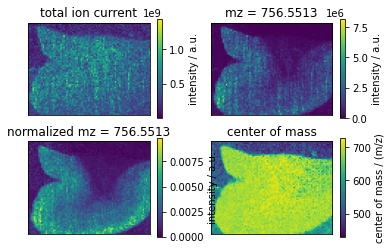

In [4]:
fig, axs = plt.subplots(2,2)

img = M_raw.get_2D(M_raw.sumpicture())
im = axs.flat[0].imshow(img)
axs.flat[0].set_xticks([])
axs.flat[0].set_yticks([])
axs.flat[0].set_title('total ion current')
fig.colorbar(im, ax = axs.flat[0], label = 'intensity / a.u.')

mz = mzs[0]
#753.588017481237#756.5513
img = M_raw.get_2D(M_raw.massvec(mz))
im = axs.flat[1].imshow(img)
axs.flat[1].set_xticks([])
axs.flat[1].set_yticks([])
axs.flat[1].set_title('mz = 756.5513')
fig.colorbar(im, ax = axs.flat[1], label = 'intensity / a.u.')

M_raw.normalize()    #data is changed in place, multiple execution of code block will alter the first two plots, if the prior code block is not re-executed as well
img = M_raw.get_2D(M_raw.massvec(mz))
im = axs.flat[2].imshow(img)
axs.flat[2].set_xticks([])
axs.flat[2].set_yticks([])
axs.flat[2].set_title('normalized mz = 756.5513')
fig.colorbar(im, ax = axs.flat[2], label = 'intensity / a.u.')

img = M_raw.get_2D(M_raw.center_of_mass())
im = axs.flat[3].imshow(img)
axs.flat[3].set_xticks([])
axs.flat[3].set_yticks([])
axs.flat[3].set_title('center of mass')
fig.colorbar(im, ax = axs.flat[3], label = 'center of mass / (m/z)')
plt.show()